In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion, omnipush_datasets

import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind')
# plt.style.use('seaborn-poster')

In [9]:
def eval_experiment(experiment_name, omnipush=False):
    # Experiment configuration
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force']),
    )

    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )

    weight_model = fusion.CrossModalWeights(state_dim=1)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_fusion_model,
        optimizer_names=[
            "e2e_fusion",
            "e2e_image",
            "e2e_force",
            "dynamics_image",
            "dynamics_force",
            "dynamics_recurrent_image",
            "dynamics_recurrent_force",
            "measurement_image",
            "measurement_force",
        ]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    if omnipush:
        eval_trajectories = omnipush_datasets.load_trajectories(("simpler/val.hdf5", 200), **dataset_args)
    else:
        dataset_args['start_timestep'] = 100
        eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 100), **dataset_args)
    
    # Plotting, etc
    phases = [
#         'phase_0_dynamics_pretrain',
#         'phase_1_dynamics_pretrain_recurrent',
#         'phase_2_measurement_pretrain',
#         'phase_3_e2e_individual',
        'phase_4_e2e_joint',
#          'phase_4_e2e_joint_unfrozen',
    ]
    print(buddy.checkpoint_labels)
    for phase in phases:
        try:
            buddy.load_checkpoint(label=phase)
            pass
        except FileNotFoundError:
            print(f"Skipping {phase}")
            continue

        print(f"Evaluating {phase}")
        pf_fusion_model.image_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        pf_fusion_model.force_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        
        with torch.no_grad():
            panda_training.rollout_and_eval(
                pf_fusion_model,
                eval_trajectories,
                start_time=0,
                max_timesteps=1000,
                particle_count=200,
                noisy_dynamics=True,
                true_initial=True)


[buddy-dpf_omnipush_fusion_lr1e-5_uf] Using device: cuda
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Available checkpoint labels: ['0000000000217208', 'phase_4_e2e_joint']
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Read checkpoint from path: checkpoints/dpf_omnipush_fusion_lr1e-5_uf-0000000000217208.ckpt
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Loaded checkpoint at step: 217208
['0000000000217208', 'phase_4_e2e_joint']
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Read checkpoint from path: checkpoints/dpf_omnipush_fusion_lr1e-5_uf-phase_4_e2e_joint.ckpt
[buddy-dpf_omnipush_fusion_lr1e-5_uf] Loaded checkpoint at step: 217208
Evaluating phase_4_e2e_joint



0.14276170962195103


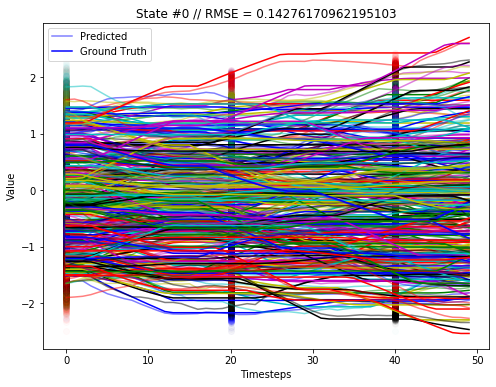

0.1495812702844899


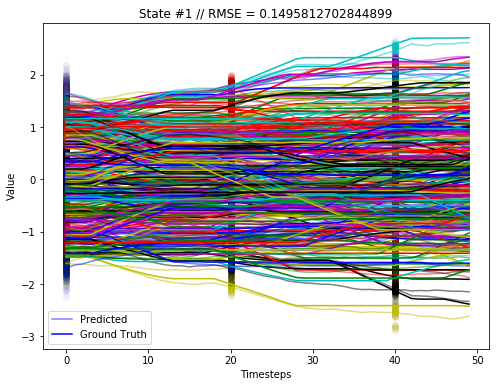

In [8]:
eval_experiment("dpf_omnipush_fusion_lr1e-5_uf", omnipush=True)

In [ ]:
eval_experiment("dpf_fusion_mujoco_blackout0_unfrozen")

[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-0000000000405644.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
Evaluating phase_4_e2e_joint



0.03529499311195505


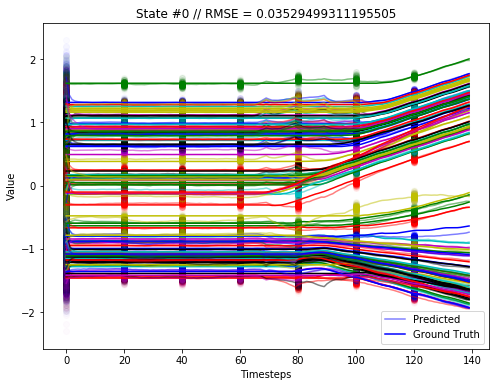

0.03716220401747442


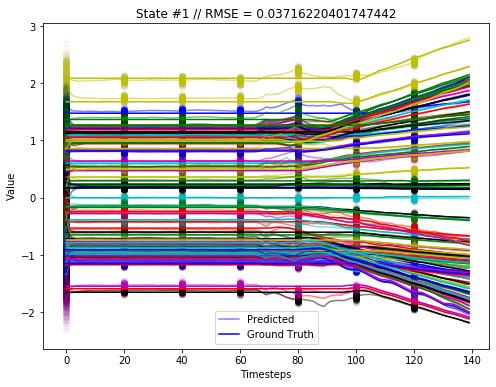

In [11]:
eval_experiment("dpf_fusion_mujoco_blackout0_2x_tuned")

In [ ]:
eval_experiment("dpf_fusion_mujoco_blackout4_2x_tuned")

In [ ]:
eval_experiment("dpf_fusion_mujoco_blackout8_2x_tuned")

[buddy-dpf_fusion_mujoco_seq5_fixed] Using device: cuda
[buddy-dpf_fusion_mujoco_seq5_fixed] Loaded metadata: {'image_blackout_ratio': 0.0, 'sequential_image_rate': 5, 'start_timestep': 0, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_fusion_mujoco_seq5_fixed] Available checkpoint labels: ['0000000000023000', '0000000000024000', '0000000000025000', '0000000000026000', '0000000000026725', 'phase_2_measurement_pretrain', 'phase_3_e2e_individual', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_fixed] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq5_fixed-0000000000026725.ckpt
[buddy-dpf_fusion_mujoco_seq5_fixed] Loaded checkpoint at step: 26725
['0000000000023000', '0000000000024000', '0000000000025000', '0000000000026000', '0000000000026725', 'phase_2_measurement_pretrain', 'phase_3_e2e_individual', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_fixed] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq


0.029868327594074436


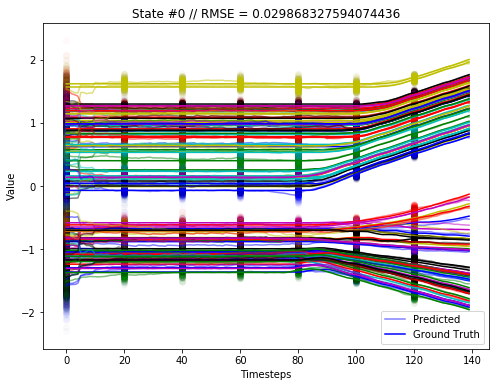

0.026930772149652716


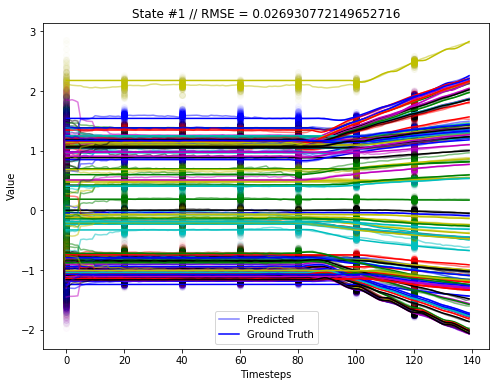

In [11]:
eval_experiment("dpf_fusion_mujoco_seq5_fixed")